# M508 Final Project: Hate Speech Classification using NLP
# Author: Fereshteh Safarkhani

#Introduction
Nowadays everyone is using social media which is a worldwide communication platform to  open dialogue accross communities. Although this openness makes this space very harmful and offensive language like hate speech, racism, and misogyny or etc that can effect mental health and safety. Cheking these manually is not fast enought specially in feasible at scaling it takes so much time and  not even important. Important task for tech companies are automative content moderation and protect users and meet regulatory standards.

This project focuses on prediction recognision hate speech and offensive language in online posts like tweeter. There is millions of messages in social media every day and it’s hard for people to check them all manually. So,  I use a labeled dataset of tweets to train a machine learning model that predict what tweet is hateful, offensive or just normal.


#Business Problem
Social media platforms like Twitter have a big challenge for handling harmful content like hate speech and offensive language. To keep users safe, follow the rules, and protect their brand, these platforms need smart tools to detect such content automatically.

##Main Question
How can we automatically detect and classify harmful tweets to make platforms safer?

#Business Value

User Safety: Helps to detect and remove harmful content before it spreads.

Operational Efficiency: Reduces the money need for big moderation teams by letting the system do the heavy lifting.

Law Compliance: Helps platforms be legal requirements, like content laws in the EU.

Brand Trust: Safer platform makes users feel more comfortable which keeps them coming back and being loyal.

Business Impact: Better moderation builds user trust, dont let people from leaving the platform and make the company image more strength.

##Data Collection:
The dataset is sourced from Kaggle which is available "https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset", using data of Twitter which is used for speech detection. The text is classified as 3 classes: hate-speech, offensive language, and neither. This text contains of racist, sexist, homophobic, or generally offensive which has 24783 rows and 7 columns.



#System Design
<p>The NLP pipeline includes the following components, designed to process raw tweets and deliver accurate prediction:</p>

![image.png]()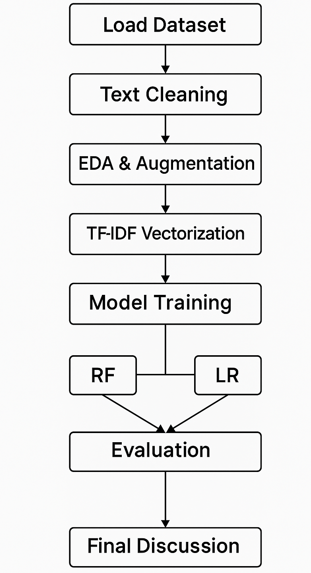

##Import Libraries

Library Usage Summary:

pandas, numpy: Data modification and numerical computations.

nltk, emoji: Text preprocessing (tokenization, stopword removal, emoji conversion)

scikit-learn: Machine learning models, TF-IDF, metrics, and train-test splitting

imbalanced-learn: SMOTE to handle class imbalance

nlpaug: Data augmentation via synonym replacement

transformers, datasets, evaluate: Hugging Face libraries for DistilBERT and evaluation

matplotlib, seaborn: Data visualization and plotting


In [ ]:
import pandas as pd
import numpy as np
import re
!pip install emoji
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import nlpaug.augmenter.word as naw
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import torch
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


True

Since the dataset is stored in my Google Drive, I mounted the drive to access the data directly in the Colab environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading Dataset
 load the dataset into DataFrame using pandas and shows its shape. it contains 24,783 rows and 7 columns.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df.shape

(24783, 7)

#Preprocessing the Dataset
 Due to our task we keep only two columns: class and tweet.


In [ ]:
df = df[['tweet', 'class']]


## Dataset Overview

Info let us see the structure of our dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24783 non-null  object
 1   class   24783 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


## Unique Class Labels

I checked the unique values in the `class` column To know the categories in it.


In [ ]:
df['class'].unique()


array([2, 1, 0])

#Label Mapping and Sentiment Encoding

Map class to sentiment labels (hate_speech, offensive, neither) and encode for modeling.

In this dataset we have 3  original numeric score, to make the sentiment labels more suitable for machine learning models. I use a function to categorize them as "hate_speech","offensive" and "neither".

Our dataset was updated cleaned tweet text and the new encoded labels, ready for training and evaluation.





In [ ]:
def map_sentiment(score):
    if score == 0:
        return "hate_speech"
    elif score == 1:
        return "offensive"
    else:  # score == 2
        return "neither"

df['sentiment'] = df['class'].apply(map_sentiment)
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['sentiment'])
df = df[['tweet', 'labels']]
print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))
print("Original Sentiment Counts:\n", df['labels'].value_counts())


Label Mapping: {'hate_speech': 0, 'neither': 1, 'offensive': 2}
Original Sentiment Counts:
 labels
2    19190
1     4163
0     1430
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

To understand better the structure of the dataset, i did two visualisation:



This bar plot shows the number of tweets labels.
We can see that dataset is very imbalanced with lots of tweets labeled as "Neither".
Imbalance class is important to be solved as it may effect our model performance, especially on the minority class. Techniques like SMOTE and data augmentation will be applied later to solve this problem.



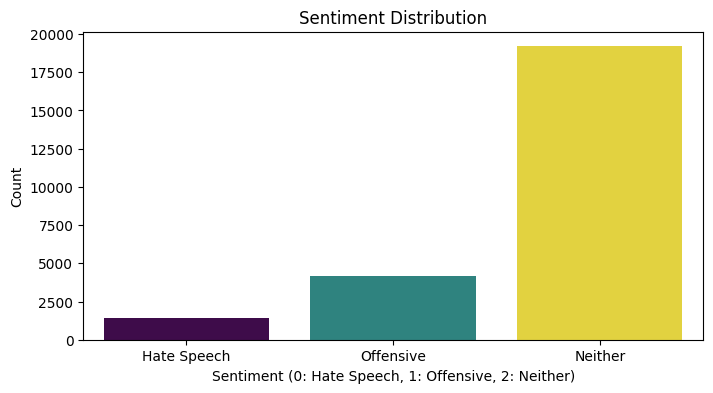

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x='labels', data=df, hue='labels', palette='viridis', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0: Hate Speech, 1: Offensive, 2: Neither)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Hate Speech', 'Offensive', 'Neither'])
plt.show()


The Histogram in the below shows how long the tweets takes in terms of character count. Most tweets are between 50 and 150 characters which is important for preprocessing decisions like setting tokenizer limits.

knowing about text length also helps in optimizing model input parameters, especially for deep learning models like DistilBERT, which have input length limitations.


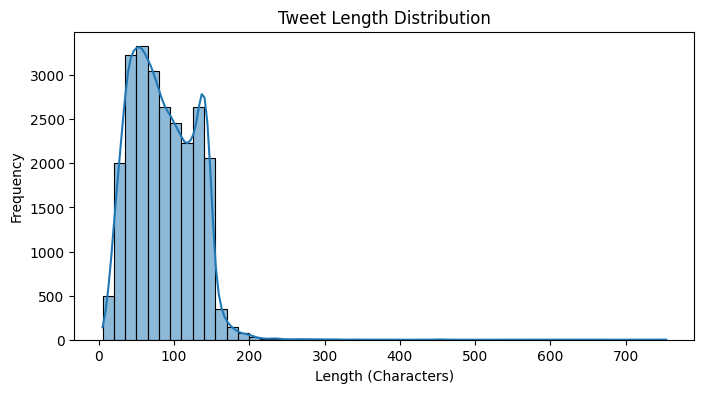

In [ ]:
df['text_length'] = df['tweet'].str.len()
plt.figure(figsize=(8, 4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Length (Characters)')
plt.ylabel('Frequency')
plt.show()


#Preprocessing Text

Before training any models, it's important to clean the  text so the machine can understand it better because tweets always has noises like emojis, hashtags, links, and slang  that are not helpful for the model.

Here’s process cleaning step-by-step:

Turns emojis into text to not to lose their meaning.

Removes noise like links, mentions, hashtags, and punctuation.

Converts everything to lowercase to make the text consistent.

Replaces slang and offensive terms with neutral words.

Keeps important words like "not" and "no" because they are important and can change the meaning.

Breaks the text into words and simplifies them.

Filters very short or useless words that don’t help us.

By doing this, we drop any rows that are empty and keep only the cleaned text and its label. This gives us a much better dataset for our machine learning models.


In [ ]:
stop_words = set(stopwords.words('english')) - {'not', 'no'}
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = emoji.demojize(tweet, delimiters=("", ""))
    tweet = re.sub(r'http\S+|@[\w]+|#\w+|[^a-zA-Z\s]', ' ', tweet)
    tweet = tweet.lower().strip()
    tweet = re.sub(r'\b(lol+|lmao+|haha+)\b', 'laugh', tweet)
    tweet = re.sub(r'\b(nic+a|nig+a)\b', 'person', tweet)
    tweet = re.sub(r'\b(gon(na)?)\b', 'going', tweet)
    tweet = re.sub(r'\b(wan(na)?)\b', 'want', tweet)
    tweet = re.sub(r'\b(bitch|nigger|hoe|fag+)\b', 'offensive_term', tweet)
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 3]
    return ' '.join(tokens)

df['text'] = df['tweet'].apply(preprocess_tweet)
df = df[df['text'] != '']
df = df[['text', 'labels']]
print("After Preprocessing Shape:", df.shape)
print("After Preprocessing:", df.head())

After Preprocessing Shape: (24743, 2)
After Preprocessing:
                                                 text  labels
0    woman complain cleaning house always take trash       1
1          dat cold tyga cuffin offensive_term place       2
2  dawg ever fuck offensive_term start confused shit       2
3                                   look like tranny       2
4  shit hear might true might faker offensive_ter...       2


#Remove Duplicates
To avoid biasing the model i checked and removed duplicates.

In [ ]:
df = df.drop_duplicates(subset=['text'])
print("After Removing Duplicates Shape:", df.shape)

After Removing Duplicates Shape: (22928, 2)


#Augmentation Methode for imbalance dataset

i used Augmentation because data was imbalanced specially hate-speech was very few, by using synonym replacement to generate some examples for it to make the model more balanced  better performance for the model.


In [ ]:
aug = naw.SynonymAug(aug_p=0.3)
hate_speech_df = df[df['labels'] == 0]
augmented_texts = []
for _ in range(2):
    augmented_texts.extend(hate_speech_df['text'].apply(lambda x: aug.augment(x)[0]))
augmented_df = pd.DataFrame({'text': augmented_texts, 'labels': 0})
df = pd.concat([df, augmented_df], ignore_index=True)
print("New Dataset Shape:", df.shape)
print("New Sentiment Counts:\n", df['labels'].value_counts())


New Dataset Shape: (25544, 2)
New Sentiment Counts:
 labels
2    17647
1     3973
0     3924
Name: count, dtype: int64


#Data Splitting


To have a better evaluation, I split data into 3 parts: training (70%), validation (15%), and test (15%) sets. while making sure each split keeps the original class distribution.

The training set is used to teach the model.

The validation set helps fine tune and evaluate different models and hyperparameters during development.

The test set is not even touched until the final evaluation to measure of best model performance.

I made sure the class distribution stays the same across all sets by using stratify.

In [ ]:
X = df['text']
y = df['labels']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print("Train Shape:", (len(X_train), 2), "Val Shape:", (len(X_val), 2), "Test Shape:", (len(X_test), 2))
print("Train Class Distribution:\n", pd.Series(y_train).value_counts())
print("Val Class Distribution:\n", pd.Series(y_val).value_counts())
print("Test Class Distribution:\n", pd.Series(y_test).value_counts())

Train Shape: (17880, 2) Val Shape: (3832, 2) Test Shape: (3832, 2)
Train Class Distribution:
 labels
2    12352
1     2781
0     2747
Name: count, dtype: int64
Val Class Distribution:
 labels
2    2648
1     596
0     588
Name: count, dtype: int64
Test Class Distribution:
 labels
2    2647
1     596
0     589
Name: count, dtype: int64


#Text Vectorization with TF-IDF

Since machine learning models can’t work with raw text, I used TF-IDF to convert tweets into numbers and make it suitable for traditional machine learning models.

TF stands for Term Frequency that Counts how many times a word appears in a document.

IDF: Reduces the weight of  common words that appear in documents.

min_df: Ignores rare words to reduce noise.

TfidfVectorizer keep only the 10,000 most important words or n-grams from our dataset.

This allows our traditional model which are Logistic regression and random forests learn better from the text data.




In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, min_df=2, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF Shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)

TF-IDF Shapes: (17880, 10000) (3832, 10000) (3832, 10000)


#Using SMOTE
I applied SMOTE for solving class imbalance. This  creates examples of the smaller class to have a balanced dataset for training, which helps the model better learn.
This method makes sure that training data is balanced by all three classes (hate speech, offensive, neither). The validation and test sets stays untouched so the evaluation will be fair realistic.

In [ ]:
smote = SMOTE(random_state=42)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
print("SMOTE Train Shape:", X_train_tfidf_smote.shape)
print("SMOTE Train Class Distribution:\n", pd.Series(y_train_smote).value_counts())

SMOTE Train Shape: (37056, 10000)
SMOTE Train Class Distribution:
 labels
0    12352
1    12352
2    12352
Name: count, dtype: int64


# 10. Traditional Machine Learning



#Random Forest Classifier


In this step, I trained a Random Forest classifier using a grid search to tune it with optimizing different parameters.. I used some  values  parameters such as:
Number of trees (n_estimators)

Maximum tree depth (max_depth)

Minimum number of samples required at a leaf node (min_samples_leaf)

Splitting criterion (gini or entropy)

I applied 5-fold cross validation that means the training data was split into 5 parts. The model was trained on 4 parts and validated on the 5th it is rotating each time that help better evaluation.

After finding the best parameter, I used the RF to predict on the validation set, and checked its accuracy. Then, I tested the model on the test set, which was never seen during training or tuning. This showed how well the model can generalize on unseen data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
target_names = ['hate_speech', 'offensive', 'neither']

rf_param_grid = {'n_estimators': [100, 200],'max_depth': [10, 20],'min_samples_leaf': [1, 2],'criterion': ['gini', 'entropy']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
rf_grid.fit(X_train_tfidf_smote, y_train_smote)
rf_best = rf_grid.best_estimator_
val_preds_rf = rf_best.predict(X_val_tfidf)

print("Best Params RF:", rf_grid.best_params_)
print("Validation Accuracy:", accuracy_score(y_val, val_preds_rf))
print("Validation Report:\n", classification_report(y_val, val_preds_rf, target_names=target_names))

test_preds_rf = rf_best.predict(X_test_tfidf)

print("Test Accuracy:", accuracy_score(y_test, test_preds_rf))
print("Test Report:\n", classification_report(y_test, test_preds_rf, target_names=target_names))


Best Params RF: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
Validation Accuracy: 0.8288100208768268
Validation Report:
               precision    recall  f1-score   support

 hate_speech       0.67      0.50      0.57       588
   offensive       0.65      0.90      0.76       596
     neither       0.91      0.89      0.90      2648

    accuracy                           0.83      3832
   macro avg       0.74      0.76      0.74      3832
weighted avg       0.83      0.83      0.83      3832

Test Accuracy: 0.8201983298538622
Test Report:
               precision    recall  f1-score   support

 hate_speech       0.65      0.47      0.55       589
   offensive       0.65      0.91      0.76       596
     neither       0.91      0.88      0.89      2647

    accuracy                           0.82      3832
   macro avg       0.73      0.75      0.73      3832
weighted avg       0.83      0.82      0.82      3832



We can see that best parameters were 200 trees, max depth 20, and entropy as the splitting rule.

On the validation set, the model got 82.9% accuracy and performed best on the "neither" class.

The test accuracy was 82%, showing decent generalization. Overall, it is not great at catching hate speech which is where a deep learning model like DistilBERT can do better.


# Logistic Regression Classifier

I used Logistic Regression as one of the baseline models and applied GridSearchCV to find the best hyperparameters for improve performance.
I used 5-fold cross-validation on the training set to evaluate all hyperparameter combinations:
 The model was trained on the SMOTE-balanced training set, validated on a hold-out validation set, and finally tested on unseen data.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

parameters_grid = { "criterion": ["gini", "entropy"],"n_estimators": [200,250], "max_depth": [10, 20],"min_samples_leaf": [2,4],}
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2'],'solver': ['lbfgs'], 'class_weight': ['balanced', None]}
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid,
    cv=5,scoring='accuracy',n_jobs=-1)

grid_search_lr.fit(X_train_tfidf_smote, y_train_smote)
best_lr_model = grid_search_lr.best_estimator_
val_preds = best_lr_model.predict(X_val_tfidf)

print(" Validation Accuracy:", accuracy_score(y_val, val_preds))
print(" Validation Report:\n", classification_report(y_val, val_preds, target_names=target_names))
test_preds = best_lr_model.predict(X_test_tfidf)
print(" Test Accuracy:", accuracy_score(y_test, test_preds))
print(" Test Report:\n", classification_report(y_test, test_preds, target_names=target_names))


 Validation Accuracy: 0.8619519832985386
 Validation Report:
               precision    recall  f1-score   support

 hate_speech       0.69      0.76      0.72       588
   offensive       0.78      0.84      0.81       596
     neither       0.93      0.89      0.91      2648

    accuracy                           0.86      3832
   macro avg       0.80      0.83      0.81      3832
weighted avg       0.87      0.86      0.86      3832

 Test Accuracy: 0.8483820459290188
 Test Report:
               precision    recall  f1-score   support

 hate_speech       0.64      0.71      0.68       589
   offensive       0.78      0.86      0.82       596
     neither       0.92      0.88      0.90      2647

    accuracy                           0.85      3832
   macro avg       0.78      0.82      0.80      3832
weighted avg       0.85      0.85      0.85      3832



As it is clear LR model got 86.1% accuracy on the validation set and 84.8% on the test set.

It performed well overall, especially on the "neither" and "offensive" classes. The "hate speech" class had lower precision. It is better than Random Forest and was more balanced across all three classes.

#Deep Learning Approach


#Training DistilBERT

###Tokenize Text with DistilBERT

To use DistilBERT, I needed to convert the text into a format it can understand. I used Hugging Face’s AutoTokenizer with the "distilbert-base-uncased" model.

The tokenizer handles:

Lowercasing all text (since it’s uncased),

Breaking sentences into word pieces (called tokens),

Padding and truncating the text so everything is the same length (max 128).

Then, I created three dataframes: one for training, one for validation, and one for testing. Each one had two columns: text and labels.

After that, I converted these into Hugging Face Dataset objects and applied the tokenizer using .map() with batched=True. This step is important because the Hugging Face Trainer works with their own dataset format, not just pandas.

This setup made the data ready to the DistilBERT model for better tuning.



In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

train_df = pd.DataFrame({'text': X_train, 'labels': y_train})
val_df   = pd.DataFrame({'text': X_val, 'labels': y_val})
test_df  = pd.DataFrame({'text': X_test, 'labels': y_test})
train_dataset = Dataset.from_pandas(train_df).map(preprocess_function, batched=True)
val_dataset   = Dataset.from_pandas(val_df).map(preprocess_function, batched=True)
test_dataset  = Dataset.from_pandas(test_df).map(preprocess_function, batched=True)


Map:   0%|          | 0/17880 [00:00<?, ? examples/s]

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

###Setting Up DistilBERT for Training


Before training the model, I loaded Hugging Face’s built-in accuracy metric to measure how well the model performs during evaluation. I also created a simple function that takes the model’s raw outputs (logits) that picks the class with the highest score and compares it to the true label to know accuracy.

Then I loaded the pre trained DistilBERT model for classification and set it up to classify between 3 labels: hate speech, offensive, and neither.

For training, I defined all the hyperparameters using the TrainingArguments class:

I set the learning rate to 2e-5, which is usually good for fine-tuning transformers.

Used a batch size of 16 for both training and evaluation.

Set the training to run for 8 full epochs.

Enabled weight decay (0.01) for prevent overfitting.

Used eval_strategy="epoch" to check model performance at the end of each epoch.

Enabled load best model at end=True to keeps the version with the best accuracy.

Turned on fp16 for faster training if available.

Limited the number of saved checkpoints to 1 to save space.

Disabled logging to WandB or other external platforms.

This setup makes sure that the model is trained properly and automatically keeps the best performing version based on validation accuracy.

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
from transformers import AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
training_args = TrainingArguments(
    output_dir="./results",
    run_name="hate_speech_classification",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    save_total_limit=1,
    report_to="none"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Train the DistilBERT Model

I used Hugging Face’s Trainer to train the DistilBERT model because it makes the whole process easier and takes care of training, evaluation, and saving the model automatically.

I just had to give it the model, the training settings, the datasets, a padding helper, and a small function to calculate accuracy. It trained the model for 8 rounds (epochs) and checked how well it was doing on the validation set after each one.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("./results/distilbert")
print("✅ DistilBERT Training Completed!")


Epoch,Training Loss,Validation Loss,Accuracy
1,0.101600,0.660755,0.874478
2,0.060900,0.819758,0.885177
3,0.034000,0.763511,0.886743
4,0.028300,0.763005,0.900835
5,0.020100,0.868518,0.891180
6,0.022400,0.864188,0.893528
7,0.011200,0.867939,0.900835
8,0.005800,0.873228,0.901879


✅ DistilBERT Training Completed!


It is now clear that the  accuracy on the validation set is increasing with each epoch. at the end which is  8th epoch, it could get 90.2% accuracy, which was the best result.

The training loss was falling down and it shows that the model was learning well. Although the validation loss was going ups and downs and not constant, the accuracy stayed strong that means the model wasn’t overfitting and was generalizing well.

#Evaluation


After training, I tested the DistilBERT model on the unseen data test set to check how well it really works.

I used the Trainer's .predict() method to get the model’s predictions and then compared them to the actual labels using accuracy and a classification report.

This gave me how the model did work on each 3 classes, showing precision, recall, and F1-scores. It confirms that the model was performing well and not just memorizing the training data.

In [ ]:

unique_classes = np.unique(y_test)
target_names = [label_encoder.inverse_transform([i])[0] for i in unique_classes]
label_encoder = LabelEncoder()
label_encoder.fit(['hate_speech', 'offensive', 'neither'])
test_predictions = trainer.predict(test_dataset)
y_pred_test_bert = np.argmax(test_predictions.predictions, axis=-1)
print("Test Accuracy (DistilBERT):", accuracy_score(y_test, y_pred_test_bert))
print("Test Report (DistilBERT):")
print(classification_report(y_test, y_pred_test_bert, target_names=target_names, labels=unique_classes))


Test Accuracy (DistilBERT): 0.9008350730688935
Test Report (DistilBERT):
              precision    recall  f1-score   support

 hate_speech       0.84      0.77      0.80       589
     neither       0.85      0.84      0.84       596
   offensive       0.92      0.95      0.93      2647

    accuracy                           0.90      3832
   macro avg       0.87      0.85      0.86      3832
weighted avg       0.90      0.90      0.90      3832



We got 90.08% accuracy in our DistilBERT model on the test set which is the best between all other models I used here.

It performed well on the offensive class wwith precision 0.92 and recall 0.95. For hate speech class we could get F1-score of 0.80 which is a much better in comparison with traditional models.

This shows the model is balanced and consistent across our 3 classes that means it can be trusted to handle real-world moderation tasks effectively.


### Confusion Matrix

For better understanding how the DistilBERT model performs on each class, We can see the confusion matrix below.
The X-axis shows the predicted classes, and the Y-axis shows the actual ones. The color and numbers shows where the model is getting things right  or confusing one class for another.

It shows that most predictions were correct,
especially for the offensive and neither classes. There were still some misclassifications between hate speech and offensive, but overall the matrix confirms that the model handles the task well and doesn’t confuse the classes too often.

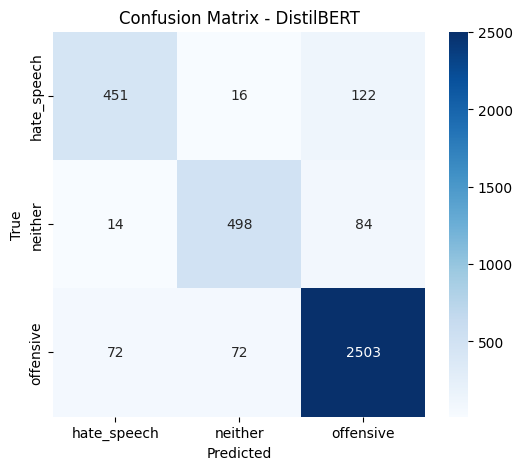

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_test_bert), annot=True, fmt='d',
            cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - DistilBERT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()


## Conclusion
My Project is focused on detecting hate speech and offensive content in tweets using traditional and deep learning models.

Traditional models we used are Logistic Regression and Random Forest that could get accuracy (around 82–85%). While, deep learning by DistilBERT and hyper paramethers could get a strong 90.08% test accuracy which is almost 5% higher and better precision and recall, it shows it v is ery reliable and can be use for future with new dataset.

I also used SMOTE for balancing 3 clases and synonym based augmentation to have more data in minority class to have better prformance for model training and reduce bias.

#References:
https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset